In [3]:
### Imports and Initial Model Setup ###
import time
import autograd.numpy as np
from autograd import jacobian, hessian
import pandas as pd
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, WhiteKernel
from scipy.spatial.distance import cdist
from scipy.integrate import solve_ivp
import scipy
from pyDOE import lhs
import scipy
import matplotlib.pyplot as plt
from itertools import cycle
start_time = None # Initialize a None time pbject outside functional scopes. Used for process hang catching.

# Linear interpolation function
def LinearDelay(Y, state, t):
    t_delay = max(0, t)
    L2 = np.searchsorted(Y.history[:, 0], t_delay, side='left')
    L1 = L2 - 1

    Y1 = Y.history[L1, state + 1]
    t1 = Y.history[L1, 0]
    Y2 = Y.history[L2, state + 1]
    t2 = Y.history[L2, 0]

    state_delay = Y1 + (t_delay - t1) * (Y2 - Y1) / (t2 - t1)
    state_delay = np.clip(state_delay, a_min=0.0, a_max=None)
    return state_delay

# calculate cumulative auc for each state of ODE system solution
def cauc(time, sol):
    
    dt = np.diff(time)
    # For each state, calculate the cumulative AUC
    cumulative_auc = np.zeros_like(sol)
    for i in range(len(sol)):
        cumulative_auc[i][1:] = np.cumsum((sol[i][:-1] + sol[i][1:]) / 2 * dt)
    return cumulative_auc

# Calculate the log likelihood of a parameter set
def log_likelihood(sse, n, sigma_sq):
    constant_term = -n/2 * np.log(2 * np.pi)
    variance_term = -n/2 * np.log(sigma_sq)
    sse_term = -sse / (2 * sigma_sq)
    return constant_term + variance_term + sse_term

# StateHistory class for storing state histories
class StateHistory:
    def __init__(self, init_state):
        self.history = np.hstack([0, init_state])
        self.history = np.vstack([self.history, self.history])

    def update(self, t, y):
        new_entry = np.hstack([t, y])
        self.history = np.vstack([self.history, new_entry])

def evalModel(funx, p, y0, t_span, state_labels,
              t_eval=None, p_fit=None, p_fit_labels=None, state_corrections=None):
    
    state_history = StateHistory(y0)
    p_local = p.copy()

    # Update parameters if p_fit is provided
    if p_fit is not None:
        try:
            normal_p_fit = dict(zip(p_fit_labels, 10**p_fit))
        except:
            normal_p_fit = {p_fit_labels, 10**p_fit}
        for key, val in normal_p_fit.items():
            p_local[key] = val

    ode_opts = {'method': 'LSODA'}
    # Reset start_time before each solve_ivp call
    global start_time 
    start_time = None
    try:

        # Use ode_opts to unpack options
        sol = solve_ivp(funx, t_span, y0, t_eval=t_eval, 
                        args=(p_local, state_labels, state_history), **ode_opts)

    except TimeoutError:
        print('Timeout error in ODE solver.')
        return None
    except RuntimeError:
        print('Runtime error in ODE solver.')
        return None

    # Use a comprehension to apply the operations
    if state_corrections is not None:
        for state, correction in state_corrections.items():
            sol.y[state_labels.index(state),:] += 10**correction
    sol.y = sol.y.clip(min=1.0)

    return sol

### Function definitions ###
def errorfxn(p_fit, funx, p_fit_labels, p, y0, data, fit_choice, state_labels, t_span, state_corrections=None):  
    
    t_eval = data['Time'].unique()
    sol = evalModel(funx, p, y0, t_span, state_labels, t_eval=t_eval, p_fit=p_fit, p_fit_labels=p_fit_labels, state_corrections=state_corrections)
    if sol is None: return np.inf # check that the solution is stable

    penalty = 0 # Penalty for "bad behavior"
    data_labels = data.columns[0:]
    data_idx = np.where(np.isin(data_labels, fit_choice))[0]
    idx = np.insert(data_idx, 0, [0,1]) # Prepend indexes 0 and 1 for Time and SampleID
    data_2d = data.iloc[:,idx] # Select only data for fitting, plus Time and SampleID
    data_2d = data_2d.set_index('Time') #Make Time the index
    ode_idx = np.where(np.isin(state_labels, fit_choice))[0] # Find where 'data to fit' occurs in ODE solutions's labels
    ode_labels = [state_labels[i] for i in ode_idx] # Create column labels
    x = sol.y[ode_idx,:].T # Filter to states which are compared to data
    x = np.log10(x, dtype='float32') # Filter to states which are compared to data
    # if all values of the state are zero, return high error
    #if np.all(x == 0): penalty = 1e6
    df = pd.DataFrame(x, columns=ode_labels, index=sol.t)  # Turn the solution into a dataframe

    Sampled = data_2d.groupby('SampleID') #Group data by Sample ID
    Sampled = [g.drop('SampleID', axis=1) for _, g in Sampled] # Drop the Sample ID column from each group
    SSE = [(g - df)**2 for g in Sampled] # Find the SSE between the data and the ODE solution for every group

    # SSE data frame has [Time] rows, [State] columns, and [Replicate] pages
    SSE = pd.concat(SSE, axis=1).sum(axis=1) # Sum the SSE across the replicate dimension
    SSE = SSE.sum(axis=0) # Sum the SSE across the time dimension
    cost = penalty + SSE.sum(axis=0) # Sum the SSE across the state dimension
        
    return np.log10(cost)  

# Define functions in Autograd to determine the jacobian and hessian of the errorfxn for later use by scipy's minimize.
jacobian_errorfxn = jacobian(errorfxn)
hessian_errorfxn = hessian(errorfxn)
# Convert the ArrayBox type to numpy array for compatibility with scipy's minimize
jacobian_errorfxn = np.array(jacobian_errorfxn)
hessian_errorfxn = np.array(hessian_errorfxn)

#  cumulative auc for each state of ODE system solution
def cauc(time, sol):
    
    dt = np.diff(time)
    # For each state, calculate the cumulative AUC
    cumulative_auc = np.zeros_like(sol)
    for i in range(len(sol)):
        cumulative_auc[i][1:] = np.cumsum((sol[i][:-1] + sol[i][1:]) / 2 * dt)
    return cumulative_auc

def plot_1d_subplot(ax, parameter_values, error_map, bounds, parameter_index, parameter_label, kernel_instance):
    # Extract the bounds for the current parameter
    param_bounds = bounds.lb[parameter_index], bounds.ub[parameter_index]

    # Fit the GP model
    gp = GaussianProcessRegressor(kernel=kernel_instance, n_restarts_optimizer=15)
    gp.fit(parameter_values.reshape(-1, 1), error_map)

    # Generate predictions for the plot
    x_pred = np.atleast_2d(np.linspace(param_bounds[0], param_bounds[1], 1000)).T
    y_pred, sigma = gp.predict(x_pred, return_std=True)

    # Plot the prediction and the confidence interval
    ax.fill_between(x_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5)
    ax.plot(x_pred, y_pred, label='GP mean prediction')
    ax.scatter(parameter_values, error_map, c='red', s=50, zorder=10, edgecolors=(0, 0, 0))

    ax.set_xlabel(parameter_label)
    ax.set_ylabel('Error')
    ax.set_title('Gaussian Process Regression Fit')
    ax.legend()

def plot_2d_gp_subplot(ax, fig, parameter_pair, error_map, kernel_instance, kernel_label, bounds, parameter_labels):
    # Fit the GP model
    gp = GaussianProcessRegressor(kernel=kernel_instance, n_restarts_optimizer=15)
    gp.fit(parameter_pair, error_map)

    # Create a grid over the space
    x_min, x_max = bounds.lb[0], bounds.ub[0]
    y_min, y_max = bounds.lb[1], bounds.ub[1] 
    grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    # Predict the function over the grid
    grid_z, grid_sigma = gp.predict(grid_points, return_std=True)
    grid_z = grid_z.reshape(grid_x.shape)
    grid_sigma = grid_sigma.reshape(grid_x.shape)

    # Normalize the errors for plotting
    error_range = [error_map.min(), error_map.max()]
    norm = plt.Normalize(vmin=error_range[0], vmax=error_range[1])

    # Plot the mean prediction surface with normalized error values
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=64, cmap='viridis', norm=norm)
    fig.colorbar(contour, ax=ax, label='Mean Prediction')

    # Overlay the data points with the same colormap as the surface and normalized error values
    scatter = ax.scatter(parameter_pair[:, 0], parameter_pair[:, 1], c=error_map, cmap='viridis', norm=norm, edgecolors='k', label='Evaluated Points')
    fig.colorbar(scatter, ax=ax, label='Log Likelihood')
    ax.set_xlabel(parameter_labels[0])
    ax.set_ylabel(parameter_labels[1])
    ax.set_title(f'GP with {kernel_label}')
    ax.legend()
    
def plot_parameters_subplots(parameter_map, error_map, bounds, parameter_labels, kernel, kernel_name, plot_mode='1D'):
    
    num_parameters = parameter_map.shape[1]

    if num_parameters == 1 or plot_mode == '1D':
        # Create a figure with subplots for each parameter
        fig, axs = plt.subplots(num_parameters, figsize=(6, 4 * num_parameters))
        if num_parameters == 1:
            axs = [axs]  # Ensure axs is a list for consistent indexing
        for idx, ax in enumerate(axs):
            individual_parameters = parameter_map[:, idx] # Extract the individual parameter values for the current set
            #print('parameter labels', parameter_labels)
            plot_1d_subplot(ax, individual_parameters, error_map, bounds, idx, parameter_labels.iloc[idx], kernel)
            ax.set_title(kernel_name)
    
        plt.tight_layout()
        plt.show()
    elif plot_mode == '2D':
        pairs = list(combinations(range(num_parameters), 2))
        grid_size = len(pairs)

        if grid_size == 1:  # If only one pair, create a 1x1 subplot
            fig, ax = plt.subplots(figsize=(5, 5))
            plot_2d_gp_subplot(ax, fig, parameter_map[:, [pairs[0][0], pairs[0][1]]], error_map, kernel, kernel_name, bounds, [parameter_labels[0], parameter_labels[1]])
        else:  # Create the nearest square grid that will hold all pairs
            nrows = ncols = int(np.ceil(np.sqrt(grid_size)))
            fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
            axs = axs.ravel()
            for i, (param1, param2) in enumerate(pairs):
                if i < grid_size:
                    specific_bounds = scipy.optimize.Bounds(
                        [bounds.lb[param1], bounds.lb[param2]], 
                        [bounds.ub[param1], bounds.ub[param2]]
                    )
            
                    label1 = parameter_labels[param1]
                    label2 = parameter_labels[param2]

                    plot_2d_gp_subplot(
                        axs[i], fig, 
                        parameter_map[:, [param1, param2]], 
                        error_map, 
                        kernel, 
                        kernel_name, 
                        specific_bounds, 
                        [label1, label2]
                    )
                else:
                    axs[i].axis('off')  # Hide unused subplots
    plt.tight_layout()
    plt.show()

# ODE Plotting
def plot_solution(sol, ax, state, states, color, x_ticks, scale):
    ODE_idx = states.index(state)  # Find index of the state in the ODE solution
    if scale == 'log':
        ax.plot(sol.t, np.log10(sol.y[ODE_idx, :].clip(min=1.0)), color=color, label='Model')  # Plot each state
    else:
        ax.plot(sol.t, sol.y[ODE_idx, :], color=color, label='Model')

    # Add legend, title, labels, etc., for the subplot
    ax.legend(loc='upper right', fontsize=14)
    ax.set_title(', '.join(state))  # Set title to be a comma-separated list of states
    ax.set_xlabel('Days Post Infection')
    log_string = 'log10(' + state +')'
    ax.set_ylabel(log_string)
    ax.set_xticks(x_ticks)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)
  
# Unified plotting for ODE solutions, data, and external models
def ModelPlotting(sol, t_span, include, scale='log', figsize=(10,10), data=None, states=None,  title=None, comp=None, color_dict=None):
    x_ticks = np.arange(0, t_span[-1], 2)  # x-ticks on 2-day intervals
    n_subplots = len(include)  # Determine the number of subplots required from states size

    # Determine the number of rows and columns required for a roughly square subplot grouping
    n_rows = int(np.ceil(np.sqrt(n_subplots)))
    n_cols = int(np.ceil(n_subplots / n_rows))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)  # Create a figure with the required number of rows and columns

    # Flatten axs if it's 2D (for ease of indexing) or wrap it in a list if it's a single Axes object
    axs = [axs] if not hasattr(axs, 'flatten') else axs.flatten()
    x_ticks = np.arange(0, t_span[-1], 2)  # x-ticks on 2-day intervals
    # Plotting loop

    for i, state in enumerate(include):
        ax = axs[min(i, len(axs)-1)]  # Use min to handle edge case of fewer subplots than states
        if isinstance(sol, list):
            for idx, s in enumerate(sol):
                color = color_dict[idx] if color_dict else 'black'
                plot_solution(s, ax, state, states, color, x_ticks, scale)
        else:
            color = color_dict[0] if color_dict else 'black'
            plot_solution(sol, ax, state, states, color, x_ticks, scale)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        if j < len(axs):
            axs[j].axis('off')

    # Add data if it exists
    if data is not None:
        # Calculate statistics for each state
        se = data.groupby('Time').agg(np.std)
        grouped = data.groupby('Time').agg(np.mean)

        # Define a color cycle for plotting multiple datasets on the same subplot
        color_cycle = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan'])

        for i, states_to_plot in enumerate(include):
            ax = axs[min(i, len(axs)-1)]

            for stat in states_to_plot:
                if stat in data.columns:
                    yerr = se[stat]
                    ymean = grouped[stat]

                    if scale != 'log':
                        yerr = 10 ** yerr
                        ymean = 10 ** ymean

                    current_color = next(color_cycle)
                    ax.errorbar(grouped.index, ymean, yerr=yerr, fmt='o', linewidth=1.0, color=current_color, label=f'{stat}')

            ax.legend(loc='upper right', fontsize=10)

# Add a MATLAB/external/saved model for comparison
    if comp is not None:
        # Define a list of linestyles and colors for the plots
        linestyles = ['--', '-.', ':']
        colors = ['r', 'c', 'm', 'y', 'k']
        # Check if comp is a list of dataframes
        if isinstance(comp, list):
            # Loop through each dataframe in the list
            for df_idx, df in enumerate(comp):
                # Loop through included states and plot the data
                for i, stat in enumerate(include):
                    # Check if comparison model exists for the current state
                    if stat in df.columns:
                        # Select the comparison model state and filter 0's
                        comp_state = df[stat].to_numpy()
                        comp_state = comp_state.clip(min=1.0)
                        if scale == 'log':
                            axs[i//n_cols, i%n_cols].plot(df['t'], np.log10(comp_state), linestyle=linestyles[df_idx % len(linestyles)], color=colors[df_idx % len(colors)], label='MATLAB')
                        else:
                            axs[i//n_cols, i%n_cols].plot(df['t'], comp_state, linestyle=linestyles[df_idx % len(linestyles)], color=colors[df_idx % len(colors)], label='MATLAB')
        else:
            # Loop through included states and plot the data
            for i, stat in enumerate(include):
                # Check if comparison model exists for the current state
                if stat in comp.columns:
                    # Select the comparison model state and filter 0's
                    comp_state = comp[stat].to_numpy()
                    comp_state = comp_state.clip(min=1.0)
                    if scale == 'log':
                        axs[i//n_cols, i%n_cols].plot(comp['t'], np.log10(comp_state), linestyle=linestyles[0], color=colors[0], label='MATLAB')
                    else:
                        axs[i//n_cols, i%n_cols].plot(comp['t'], comp_state, linestyle=linestyles[0], color=colors[0], label='MATLAB')
                    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    return fig, axs

# Generates LHS spaced parameter sets (LHS maintained per parameter!)
def generate_parameters(n_beacons, fit_parameters, bounds):
    num_parameters = fit_parameters.shape[0]  # Number of parameters
    sample = np.zeros((n_beacons, num_parameters))

    for i in range(num_parameters):
        lb = bounds.lb[i]
        ub = bounds.ub[i]
        param_range = ub - lb
        sample[:, i] = lhs(1, samples=n_beacons).flatten()
        sample[:, i] = lb + sample[:, i] * param_range

    parameter_map = np.clip(sample, -9, 9) # Ensure all values are within the hard bounds
    return parameter_map

def generalized_kernel(kernel_type='rbf', length_scale=1.0, alpha=0.1, nu=1.5, noise_level=0.1,
                       length_scale_bounds=(1e-2, 1e2), alpha_bounds=(1e-2, 1e2),
                       nu_bounds=(1e-2, 1e2), noise_level_bounds=(1e-10, 1e+1),
                       include_noise=True):
    # Base kernel without noise
    if kernel_type == 'rbf':
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale, length_scale_bounds=length_scale_bounds)
    elif kernel_type == 'rq':
        kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=length_scale, alpha=alpha, length_scale_bounds=length_scale_bounds, alpha_bounds=alpha_bounds)
    elif kernel_type == 'matern':
        kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=length_scale, nu=nu, length_scale_bounds=length_scale_bounds)
    else:
        raise ValueError(f"Unsupported kernel type: {kernel_type}")

    # Add noise component if specified
    if include_noise:
        kernel += WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

    return kernel

In [9]:
# Define a Model Class
state_labels = ['V', 'T', 'I1', 'I2', 'E', 'FA_I1', 'FA_NFA', 'FA_pDC', 'FA_cDC', 'FA-Fi', 'FA', 'NFA', 'pDC', 'cDC', 'Fi']
fit_choice = ['FA']
plot_list = ['V', 'T', 'I1', 'I2', 'FA_I1', 'FA_NFA', 'FA_pDC', 'FA_cDC', 'FA-Fi', 'FA', 'NFA', 'pDC', 'cDC', 'Fi']
df_data = pd.read_excel('../Data/Murine Data.xlsx', sheet_name='Dynamics') # Load murine homogenized lung data
df_par = pd.read_excel('parameters/parameters_DD.xlsx',sheet_name='py') # parameter import
t_censor = 10 # Censor data with time > t_censor. Set t_censor < 0 to disable.
t_span = [0, 13] # What timespan should the integration be performed over? Time steps will be automatically determined by the solver.
y0 = np.zeros(len(state_labels)) # Initial Conditions for ODEs
y0[state_labels.index('T')] = 1E7 # Host Size estimate
y0[state_labels.index('I1')] = 75 # Initially 75 eclipse cells

# Define a Model
def DDModel(t, y, p, state_labels, state_history, timeout=30):
    global start_time # Seemingly thread-safe way to create ODE timeouts. #TODO non-global method
    if start_time is None: start_time = time.time() # First timestep of ODE system starts the clock
    if (time.time() - start_time) > timeout: raise TimeoutError('ODE Solver timeout.') #TODO investigate causes of timeouts
    y = y.clip(min=0.0)
    state_history.update(t,y) # Delay differential equations require a history of the ODE, accesible from each timestep
    s = dict(zip(state_labels, y)) #TODO de-dict. Too verbose and too slow.

    # Define a list of tuples for each delay. Each tuple contains the delay parameter, the state index and the new variable name
    delays = [('tau_FA', 'I1', 'I1_tau_FA'),
              ('tau_FA2', 'I2', 'I2_tau_FA2'),
              ('tau_FA', 'V', 'V_tau_FA'),
              ('tau_FA2', 'V', 'V_tau_FA2')]

    # Use a dictionary comprehension to create each delayed variable
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t-p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}
    
    # ODE Equations
    dV =  p['p'] * s['I2'] - p['c'] * s['V']
    dT = - p['beta'] * s['T'] * s['V']
    dI1 = p['beta'] * s['T'] * s['V'] - p['k'] * s['I1']
    dI2 =  p['k'] * s['I1']  - (p['delta_d'] * s['I2']) / (p['K_delta'] + s['I2'])
    dFA_I1 = p['sA'] * s_tau['I1_tau_FA'] ** p['nA'] + p['gA'] * s['NFA'] + p['lA'] * s['Fi'] + p['qA']*s['cDC'] + p['yA'] * s['pDC'] - p['dFA'] * s['FA']
    dFA_NFA = 0#
    dFA_pDC = 0#
    dFA_cDC = 0#
    dFA_Fi = 0#
    dFA = dFA_I1 + dFA_NFA + dFA_pDC + dFA_cDC + dFA_Fi
    dNFA = 0#
    dpDC = 0#
    dcDC = 0#
    dFi = 0#
    
    return [dV, dT, dI1, dI2, dFA_I1, dFA_NFA, dFA_pDC, dFA_cDC, dFA_Fi, dFA, dNFA, dpDC, dcDC, dFi]

# Define a Model
def Model(t, s, p):
   
    # ODE Equations
    ddt = [
    - p.beta * s.T * s.V, #T
    p.beta * s.T * s.V - p.k * s.I1, #I1
    p.k * s.I1  - (p.delta_d * s.I2) / (p.K_delta + s.I2), #I2
    p.p * s.I2 - p.c * s.V] #V
    
    return ddt

# Run the model #TODO Package all this away, as it doesn't require user interaction
fit_parameters = df_par[df_par['type'] == 'fit'].copy() # Determine which, if any, parameters should be fit
print('Fitting with ' + str(len(fit_parameters)) + ' parameters:')
for i in range(len(fit_parameters)): print(fit_parameters.iloc[i,0])
parameters = dict(zip(df_par.labels, df_par.initval)) # Import all parameters into a dictionary
bounds = scipy.optimize.Bounds(lb=fit_parameters['min'], ub=fit_parameters['max']) # Set bounds for fit parameters
initial_data = df_data[df_data['TIME'] == 0] # Determine initial value of each column in df_Data except Time and SampleID
columns = ['TIME', 'ID'] + [col for col in df_data.columns if col not in state_labels]
state_corrections = initial_data.drop(columns=columns).mean() # Create a background noise correction
print('Background noise correction:', state_corrections)
if t_censor > 0: df_data = df_data[df_data['TIME'] <= t_censor]

# Plot and get the error of the initial model
error = errorfxn(None, DDModel, None, parameters, y0=y0, data=df_data, fit_choice=fit_choice, state_labels=state_labels, t_span=t_span, state_corrections=state_corrections)
print('Initial error:', error) 
sol = evalModel(DDModel, parameters, y0, t_span, state_labels, state_corrections=state_corrections)
fig, axs = ModelPlotting(sol, t_span, include=plot_list, scale='log', figsize=(10, 10), data=df_data, states=state_labels, title='Initial Model')

Fitting with 1 parameters:
sA
Background noise correction: V      0.000000
E      5.628000
NFA    3.486278
pDC    2.979660
cDC    2.428493
Fi     3.442556
dtype: float64


KeyError: 'Time'

In [ ]:
# Set up Initial Parameter Exploration / Gaussian Process surrogate model construction
samples = 25
parameter_map = generate_parameters(samples, fit_parameters, bounds)
error_map = np.zeros(samples)
verbose = False

# Evaluate the error for each initial set of parameters #TODO multiprocess/map/batch this step
for i, params in enumerate(parameter_map):
    error_map[i] = errorfxn(params, DDModel, fit_parameters['labels'], parameters, y0=y0, data=df_data, fit_choice=['FA'], state_labels=state_labels, t_span=t_span, state_corrections=state_corrections)
    if verbose: print(f"Error for Parameters {params} is {error_map[i]}")
min_error_index = np.argmin(error_map)
min_error_parameters = parameter_map[min_error_index]
min_error_value = error_map[min_error_index]
print(f"Initial Sample Lowest Error Parameters: {min_error_parameters}")
print(f"Initial Sample Lowest Error Value: {min_error_value}")

# Defined kernel hyperparameters
length_scale = 1.0
alpha = 0.1
nu = 1.5
noise_level = 1

# Defined bounds for hyperparameters
length_scale_bounds = (1e-2, 1e2)
alpha_bounds = (1e-2, 1e2)
nu_bounds = (1e-2, 1e2)
noise_level_bounds = (1e-10, 1e+1)

# Dictionary of kernels to try, with specific additional parameters if needed
kernels = {
    'RBF': {
        'kernel_type': 'rbf',
        'length_scale': length_scale,
        'length_scale_bounds': length_scale_bounds,
        'noise_level': noise_level,
        'noise_level_bounds': noise_level_bounds
    },
    'Rational Quadratic': {
        'kernel_type': 'rq',
        'length_scale': length_scale,
        'alpha': alpha,
        'alpha_bounds': alpha_bounds,
        'length_scale_bounds': length_scale_bounds,
        'noise_level': noise_level,
        'noise_level_bounds': noise_level_bounds
    },
    'Matern': {
        'kernel_type': 'matern',
        'length_scale': length_scale,
        'nu': nu,
        'nu_bounds': nu_bounds,
        'length_scale_bounds': length_scale_bounds,
        'noise_level': noise_level,
        'noise_level_bounds': noise_level_bounds
    }
}

# Iterate over each kernel configuration and plot
for kernel_name, kernel_config in kernels.items():
    kernel_instance = generalized_kernel(**kernel_config)
    plot_parameters_subplots(parameter_map, error_map, bounds, fit_parameters['labels'], kernel_instance, kernel_name, plot_mode='1D')
    plot_parameters_subplots(parameter_map, error_map, bounds, fit_parameters['labels'], kernel_instance, kernel_name, plot_mode='2D') # TODO Fix 2D up with a GP surface

# Plot the model with the lowest error
print('Lowest Sampled Error:', error_map.min())
sol = evalModel(DDModel, parameters, y0, t_span, state_labels, p_fit=min_error_parameters, p_fit_labels=fit_parameters['labels'], state_corrections=state_corrections)
fig, axs = ModelPlotting(sol, t_span, 
                         include=plot_list,
                         scale='log', figsize=(10, 10),
                         data=df_data, states=state_labels, 
                         title='Model')

AttributeError: 'NoneType' object has no attribute 'lb'

C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)
C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)
C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)
C:\Users\jorda\App

         Current function value: -inf
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1
 message: NaN result encountered.
 success: False
  status: 3
     fun: -inf
       x: [-1.086e+00  2.352e+00]
     nit: 0
     jac: [       nan        nan]
    nfev: 3
    njev: 1
sA : 0.08197787593353084
dFA : 224.89937103786733


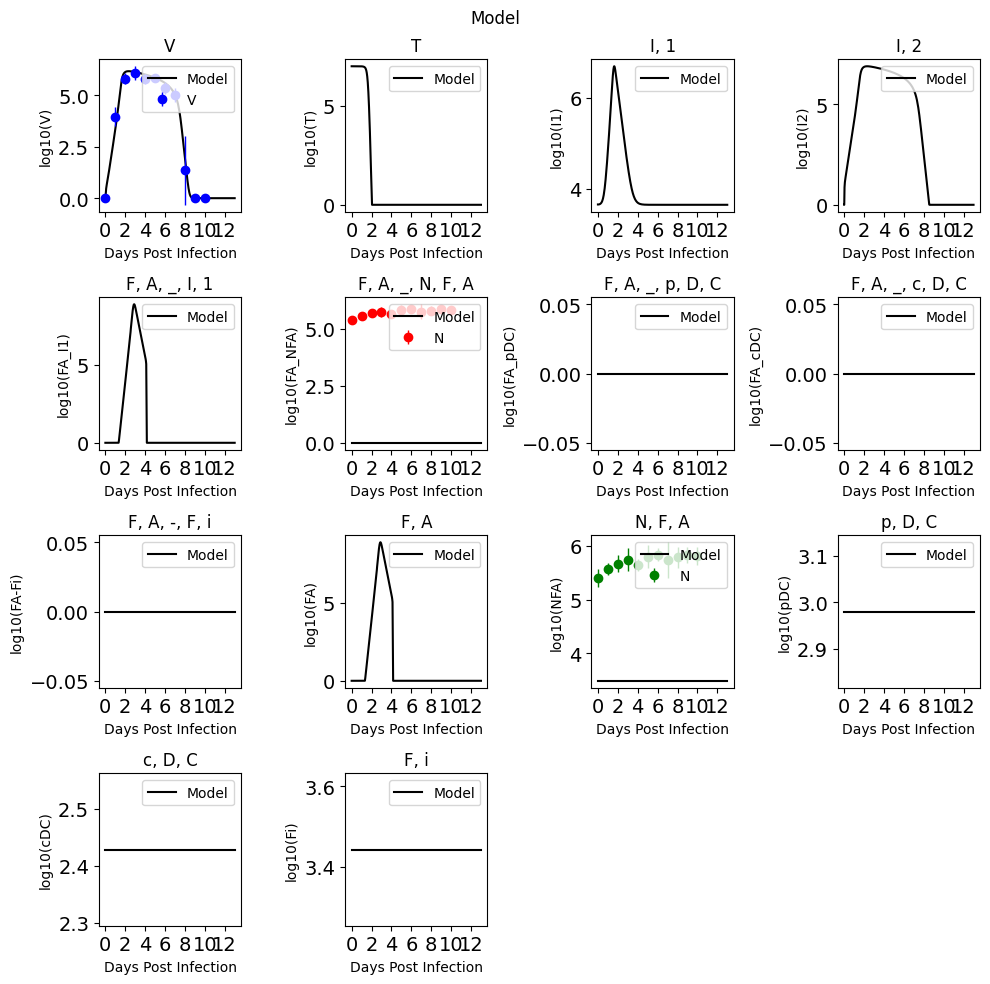

In [ ]:
# Local optimizer 
# Valid methods: Nelder-Mead, Powell, CG, BFGS, Netwon-CG, L-BFGS-B, TNC, COBYLA, SLSQP, trust-constr, dogleg, trust-ncg, trust-exact, trust-krylov, custom*
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
method = 'CG'
bounds = (bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr'] else None)
jac=(jacobian_errorfxn if method in ['CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr'] else None)
hess=(hessian_errorfxn if method in ['Newton-CG', 'trust-constr'] else None)
hessp=None
options = {'maxiter': 100, 'disp': True}
tol = None

error_args = tuple((DDModel, 
                    fit_parameters['labels'], parameters, y0,
                    df_data, fit_choice, state_labels,
                    t_span, state_corrections))
 
result = scipy.optimize.minimize(errorfxn, (parameter_map[np.argmin(error_map), :]), args=error_args, method=method, 
                                 jac=jac, hess=hess, hessp=None, bounds=bounds,
                                 constraints=None, tol=tol, callback=None, options=options)

fit_parameters['best'] = result.x #TODO: save out to parameters file

print(result)
for label,value in zip(fit_parameters['labels'], result.x):
    print(label, ':', 10**value)

# Generate a model solution with final parameters
sol = evalModel(DDModel, parameters, y0, t_span, state_labels, p_fit=fit_parameters['best'], p_fit_labels=fit_parameters['labels'], state_corrections=state_corrections)

# Plot the result
fig, axs = ModelPlotting(sol, t_span, 
                         include=plot_list,
                         scale='log', figsize=(10, 10),
                         data=df_data, states=state_labels, 
                         title='Model')

In [ ]:
### User Set up for Global Optimizer ###
break
local_kwargs  = {'method':method,
                'bounds':bounds,
                'args':error_args,
                'jac':jac,
                'hess':hess,
                'options':options}
                                
method = 'basinhopping' #dual_annealing, sim_annealing, differential_evolution, shgo, basinhopping
max_evals = int(10) #Maximum number of total ODE evaluations within a global optimizer
temp = 10 # Approximately a "jump" in error

# Run Global Optimizer
# Custom Uniform step-function for bounded basin hopping
class CustomDisplacementBounds(object):
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        print('x',x)
        range_step = self.xmax - self.xmin
        min_step = np.maximum(self.xmin - x, -self.stepsize * range_step)
        max_step = np.minimum(self.xmax - x, self.stepsize * range_step)
        print('min',min_step)
        print('max',max_step)
        print('range',range_step)

        UniformStep = np.random.uniform(low=min_step, high=max_step, size=x.shape)

        print('uniform step',UniformStep)

        xnew = x + UniformStep
        print('xnew',xnew)
        
        return xnew

# Normal step-function for unbounded basin hopping
class NormalDisplacementBounds(object):
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        range = self.xmax - self.xmin

        NormalStep = np.random.default_rng().normal(loc=x, scale=range*self.stepsize)
        NormalStep = np.clip(NormalStep, self.xmin.to_numpy()-x, self.xmax.to_numpy()-x)

        xnew = x + NormalStep
        
        return xnew
    
# Uniform step-function for unbounded basin hopping
class UniformDisplacementBounds(object):

    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):

        NormalStep = np.random.default_rng().uniform(self.xmin, self.xmax)
        xnew = x + NormalStep
        
        return xnew

if fit_parameters.shape[0] == 0: #return a solution from original parameters
    print('No parameters to fit')
    # Start timer
    start_time = time.time()
    # Generate a model solution
    sol = evalModel(DDModel, parameters, y0, t_span, state_labels, df_data, ad_hoc_list)
    
else: #use a global optimizer
    if method=='basinhopping':
        BH_step = NormalDisplacementBounds(fit_parameters['min'], fit_parameters['max'], stepsize=0.5)
        result = scipy.optimize.basinhopping(errorfxn, (fit_parameters['current']), niter = max_evals, minimizer_kwargs = local_kwargs, disp = True, take_step = BH_step, T = temp, interval = 0.1*max_evals, niter_success = 0.25*max_evals)

    elif method=='dual_annealing': # Currently bugged?  Local search seems to fail.
        result = scipy.optimize.dual_annealing(errorfxn, bounds=bounds, args=error_args,
                                               maxiter=max_evals, minimizer_kwargs=local_kwargs,
                                               initial_temp=temp, visit=2.62,maxfun=max_evals,
                                               no_local_search=False)

    elif method=='sim_annealing': # Replicating MATLAB ASA functionality. Works, because no local search.
        result = scipy.optimize.dual_annealing(errorfxn, bounds=bounds, args=error_args, 
                                               maxiter=max_evals, minimizer_kwargs=local_kwargs, 
                                               initial_temp=temp, visit=2.62, maxfun=max_evals, 
                                               no_local_search=True)
        
    elif method=='differential_evolution':
        result = scipy.optimize.differential_evolution(errorfxn, bounds=bounds, args=error_args, strategy='randtobest1exp',
                                maxiter=max_evals, tol=0.1, mutation=(0.5, 1),
                                recombination=0.7, seed=None, callback=None, disp=True,
                                polish=True, init='sobol', updating='immediate', atol=0.1)
    elif method=='shgo':
        result = scipy.optimize.shgo(
            func=errorfxn, bounds=bounds, args=error_args, 
            constraints=None, iters=max_evals, callback=None, 
            options=None, sampling_method='simplicial', workers=1)

    fit_parameters['best'] = result.x #TODO: save out to parameters file

    print(result)
    for label,value in zip(fit_parameters['labels'], result.x):
        print(label, ':', 10**value)


    # Generate a model solution with final parameters
    sol = evalModel(DDModel, parameters, y0, t_span, state_labels, p_fit=fit_parameters['best'], p_fit_labels=fit_parameters['labels'], state_corrections=state_corrections)

# Plot the result
fig, axs = ModelPlotting(sol, t_span, 
                         include=plot_list,
                         scale='log', figsize=(10, 10),
                         data=df_data, states=state_labels, 
                         title='Model')

SyntaxError: 'break' outside loop (990396105.py, line 2)

In [ ]:
break
# ## Monolith ###
def Model(t, y, p, state_labels, state_history, timeout=10):
    global start_time 
    if start_time is None:
        start_time = time.time()
        
    elapsed_time = time.time() - start_time
    if elapsed_time > timeout:
        raise TimeoutError("ODE Solver took >", elapsed_time, 'seconds. Aborting.')
    
    # Remove negative states arising from complex roots
    y = y.clip(min=0.0)

    state_history.update(t,y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))

    # Define a list of tuples for each delay. Each tuple contains the delay parameter, the state index and the new variable name
    delays = [('tau_CFA', 'I', 'I_tau_CFA'), 
               ('tau_FB', 'E', 'I_tau_FB'), 
               ('tau_FA', 'E', 'I_tau_FA'), 
               ('tau_CFB', 'E', 'E_tau_CFB'), 
               ('tau_GMCSF', 'MI', 'MI_tau_GMCSF'), 
               ('tau_IL6', 'MI', 'MI_tau_IL6'), 
               ('tau_T', 'I', 'I_tau_T'), 
               ('tau_TM', 'T', 'T_tau_TM')]

    # Use a dictionary comprehension to create each delayed variable
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t-p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    ### Pathogen ###
    dV =  p['p_V_I'] * s['I'] - p['d_V'] * s['V'] - 0 * p['delta_V_MI'] * s['MI'] #- p['delta_V_N'] * s['N'] # (Influenza) Virus

    ### Host Epithelial Cells ###
    dS = - p['p_E_V'] * s['S'] * s['V'] # Susceptible Cells
    dE = p['p_E_V'] * s['S'] * s['V'] - p['p_I_E'] * s['E'] # Eclipse Cells
    dI =  p['p_I_E'] * s['E']  - p['d_I'] * s['I'] - p['delta_I_T'] * s['T'] * s['I']/(p['K_I_T'] + s['I']) # Infected Cells
    dD = p['d_I'] * s['I'] + p['delta_I_T'] * s['T'] * s['I']/(p['K_I_T'] + s['I']) # Dead Cells

    ### Cytokines and Chemokines ###
    dFA =  0#p['p_FA_I'] * s_tau['I_tau_FA'] + 0*p['p_FA_CFA'] * s['CFA'] - p['d_FA'] * s['FA'] # IFNA
    dFB =  p['p_FB_I'] * s_tau['I_tau_FB']  + 0*p['p_FB_CFB'] * s['CFB'] - p['d_FB'] * s['FB'] # IFNB
    dIL6 = p['p_IL6_I'] * s['I'] + p['p_IL6_MI'] * s_tau['MI_tau_IL6'] - p['d_IL6'] * s['IL6'] # IL-6
    dGMCSF = p['p_GMSCF_E'] * s['E'] + p['p_GMCSF_MI'] * s['I']/1E7 * s_tau['MI_tau_GMCSF'] - p['d_GMCSF'] * s['GMCSF'] # GM-CSF
    dTNFA = p['p_TNFA_E'] * s['E'] + p['p_TNFA_MI'] * s['MI'] - p['d_TNFA'] * s['TNFA'] # TNFA

    ### Immune Cells
    dN = (p['p_N_IL6'] * s['IL6']) / (s['N'] + p['eps_N']) - p['d_N'] * s['N'] # Neutrophils
    dMI = p['p_MI_GMCSF'] * s['GMCSF'] / (p['eps_MI'] + s['GMCSF']) - p['d_MI'] * s['MI'] # Inflammatory Macrophages
    dT = (p['p_T_I1'] * s['I']) / (p['K_T_I'] + s['T']) + p['p_T_I2'] * s_tau['I_tau_T'] * s['T'] - p['d_T'] * s['T'] # CD8+ T Cells
    dTM = p['p_TM_T'] * s_tau['T_tau_TM'] # T Memory Cells
    dTotal_T = dT + dTM # Total T Cells
    dCFA = 0#p['p_CFA_I'] * s_tau['I_tau_CFA'] - p['d_CFA'] * s['CFA'] # IFNA Positive Cells
    dCFB = p['p_CFB_E'] * s_tau['E_tau_CFB'] - p['d_CFB'] * s['CFB'] # IFNB Positive Cells

    dydt = dV, dS, dE, dI, dD, dFA, dFB, dIL6, dGMCSF, dTNFA, dN, dMI, dT, dTM, dTotal_T, dCFA, dCFB
    
    return dydt

Pathogen = ['V'] # Pathogen label(s)
Host = ['S', 'E', 'I', 'D'] # Host Epithelial Cell States
Cyto = ['FA', 'FB', 'IL6', 'GMCSF', 'TNFA'] # Cytokines, Chemokines
Immune = ['N', 'MI', 'T', 'TM', 'Total_T', 'CFA', 'CFB'] # Immune Cells
state_labels = Pathogen + Host + Cyto + Immune # Combined list of all states
t_span = [0, 13] # What timespan should the integration be performed over?

t_censor = 17.5 # Censor data with time > t_censor. Set t_censor = -1 to disable.
if t_censor > 0:
    df_data = df_data[df_data['Time'] <= t_censor]

y0 = np.zeros(len(state_labels)) # Initial Conditions for ODEs
y0[state_labels.index('S')] = 1E7 # Host Size estimate
y0[state_labels.index('E')] = 75 # Initially 75 eclipse cells

df_par_Complete = pd.read_excel('parameters/parameters_Complete.xlsx',sheet_name='py') # parameter import
fit_parameters = df_par_Complete[df_par_Complete['type'] == 'fit'].copy() # Determine which, if any, parameters should be fit
best_parameters = df_par_Complete[df_par_Complete['type'] == 'best'].copy() # Determine which, if any, parameters are being used as 'best-overwrites' to retain information from previous parameterizations.
parameters = dict(zip(df_par_Complete.labels, df_par_Complete.initval)) #Pack all ODE parameters into a dict. #TODO Explore less verbose alternatives to dicts that retain orderless property.

# Define a dictionary with states and corresponding corrections
state_corrections = {
    'IL6': 9.39, 'GMCSF': 10.28, 'TNFA': 8.37,
    'MI': 11499, 'N': 250034, 'Total_T': 421899
}

# Dictionary of [model state string][floor, ceiling] for plotting ylim changes
ylims_dict = {'Total_T': [4.5, 7.0]} 

ode_opts={
    'method': 'LSODA',
    'rtol': 1e-4,'atol': 1e-4,
    'min_step':1e-5, 'max_step':1e-1
}

plot_labels = ['V', 'E', 'I', 'Total_T', 'FA', 'FB'] # Which data should be plotted?
fit_choice = ['V']
bounds = scipy.optimize.Bounds(lb=fit_parameters['min'], ub=fit_parameters['max'])

error_args = tuple((Model, 
                    fit_parameters['labels'], parameters, y0,
                    df_data, fit_choice, state_labels,
                    t_span, state_corrections, ode_opts,
                    best_parameters))

# Log Uniform random initial values for each parameter, within respective bounds
fit_parameters['current'] = np.random.uniform(
    low=fit_parameters['min'], high=fit_parameters['max'], size=fit_parameters.shape[0])

# Generate a model solution
sol_complete = evalModel(Model, parameters, y0, t_span, state_labels, state_corrections=state_corrections)

# Plot the result
fig, axs = ModelPlotting(sol, t_span, 
                         include=['V', 'S', 'E', 'I', 'FB', 'CFB'],
                         data=df_data, states=state_labels, 
                         figsize=(10, 10), title='Model', ylims_dict=ylims_dict)

SyntaxError: 'break' outside loop (795566314.py, line 1)

In [ ]:
break
### CAUC Histology Comparison ###
def cauc(time, sol):
    
    dt = np.diff(time)
    
    # For each state, calculate the cumulative AUC
    cumulative_auc = np.zeros_like(sol)
    cumulative_auc[1:] = np.cumsum((sol[:-1] + sol[1:]) / 2 * dt)
    return cumulative_auc

# Load MATLAB model data
df_MAT = pd.read_excel('data/MATLAB_TM.xlsx')
MAT_ActiveLesion = df_MAT['I'].values
MAT_InactiveLesion = df_MAT['CD8T'].values
MAT_Time = df_MAT['Time'].values

# There are 2 histopathology metrics to be considered:
# 1. Active Lesion, corresponding to AUC of Infected cells
ActiveLesion = sol.y[state_labels.index('I')]
ActiveLesionCAUC = cauc(sol.t, sol.y[state_labels.index('I')])
MAT_ActiveLesionCAUC = cauc(MAT_Time, MAT_ActiveLesion)

# 2. Inactive Lesion, corresponding to CD8TK colocalization
InactiveLesion = sol.y[state_labels.index('TK')]
InactiveLesionCAUC = cauc(sol.t, sol.y[state_labels.index('TK')])
MAT_InactiveLesionCAUC = cauc(MAT_Time, MAT_InactiveLesion)

# Load murine pathology data for model training and plotting
df_path = pd.read_excel('data/Limited Murine Data.xlsx', sheet_name='Pathology')
grouped = df_path.groupby('Time').agg(lambda x: np.mean(x)) # mean of the data
se = df_path.groupby('Time').agg(lambda x: np.std(x)) # standard deviation
maxes = grouped.max() # Max of each state

# Determine the limits for the python and matlab y-axes
python_auc_limits = [0, ActiveLesionCAUC.max()/maxes['ActiveLesion'], 0, InactiveLesionCAUC.max()/maxes['InactiveLesion']]
matlab_auc_limits = [0, MAT_ActiveLesionCAUC.max()/maxes['ActiveLesion'], 0, MAT_InactiveLesionCAUC.max()/maxes['InactiveLesion']]

python_raw_limits = [0, ActiveLesion.max()/maxes['ActiveLesion'], 0, InactiveLesion.max()/maxes['InactiveLesion']]
matlab_raw_limits = [0, MAT_ActiveLesion.max()/maxes['ActiveLesion'], 0, MAT_InactiveLesion.max()/maxes['InactiveLesion']]

# Plot the Active Lesion and Inactive Lesion metrics vs the data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Active Lesion subplot
ax1 = axs[0, 0].twinx()
ax1a = axs[0, 0].twinx()
axs[0, 0].errorbar(grouped.index, grouped['ActiveLesion'], yerr=se['ActiveLesion'], fmt='o', linewidth=1.0, color='blue')
axs[0, 0].set_ylim(0, 1)
ax1.plot(sol.t, ActiveLesionCAUC, color='red')
ax1a.plot(MAT_Time, MAT_ActiveLesionCAUC, color='green')
ax1.set_xlim(0, 11)
ax1.set_ylim(python_auc_limits[0], python_auc_limits[1])
ax1a.set_ylim(matlab_auc_limits[0], matlab_auc_limits[1])
axs[0, 0].set_title('Active Lesion')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Data (% Active Legion)', color='blue')
ax1.set_ylabel('Model (CAUC(Infected Cells))', color='red')
ax1a.spines['right'].set_position(('outward', 60))
ax1a.set_ylabel('MATLAB Model (CAUC(Infected Cells))', color='green')

# Inactive Lesion subplot
ax2 = axs[0, 1].twinx()
ax2a = axs[0, 1].twinx()
axs[0, 1].errorbar(grouped.index, grouped['InactiveLesion'], yerr=se['InactiveLesion'], fmt='o', linewidth=1.0, color='blue')
axs[0, 1].set_ylim(0,1)
ax2.plot(sol.t, InactiveLesionCAUC, color='red')
ax2a.plot(MAT_Time, MAT_InactiveLesionCAUC, color='green')
ax2.set_xlim(0, 11)
ax2.set_ylim(python_auc_limits[2], python_auc_limits[3])
ax2a.set_ylim(matlab_auc_limits[2], matlab_auc_limits[3])
axs[0, 1].set_title('Inactive Lesion')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Data (% Inactive Legion)', color='blue')
ax2.set_ylabel('Model (CAUC(CD8TK Cells))', color='red')
ax2a.spines['right'].set_position(('outward', 60))
ax2a.set_ylabel('MATLAB Model (CAUC(CD8TK Cells))', color='green')

# Active Lesion subplot
ax3 = axs[1, 0].twinx()
ax3a = axs[1, 0].twinx()
axs[1, 0].errorbar(grouped.index, grouped['ActiveLesion'], yerr=se['ActiveLesion'], fmt='o', linewidth=1.0, color='blue')
axs[1, 0].set_ylim(0, 1)
ax3.plot(sol.t, ActiveLesion, color='red')
ax3a.plot(MAT_Time, MAT_ActiveLesion, color='green')
ax3.set_xlim(0, 11)
ax3.set_ylim(python_raw_limits[0], python_raw_limits[1])
ax3a.set_ylim(matlab_raw_limits[0], matlab_raw_limits[1])
axs[1, 0].set_title('Active Lesion')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Data (% Active Legion)', color='blue')
ax3.set_ylabel('Model (Infected Cells)', color='red')
ax3a.spines['right'].set_position(('outward', 60))
ax3a.set_ylabel('MATLAB Model (Infected Cells)', color='green')

# Inactive Lesion subplot
ax4 = axs[1, 1].twinx()
ax4a = axs[1, 1].twinx()
axs[1, 1].errorbar(grouped.index, grouped['InactiveLesion'], yerr=se['InactiveLesion'], fmt='o', linewidth=1.0, color='blue')
axs[1, 1].set_ylim(0,1)
ax4.plot(sol.t, InactiveLesion, color='red')
ax4a.plot(MAT_Time, MAT_InactiveLesion, color='green')
ax4.set_xlim(0, 11)
ax4.set_ylim(python_raw_limits[2], python_raw_limits[3])
ax4a.set_ylim(matlab_raw_limits[2], matlab_raw_limits[3])
axs[1, 1].set_title('Inactive Lesion')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Data (% Inactive Legion)', color='blue')
ax4.set_ylabel('Model (CD8TK Cells)', color='red')
ax4a.spines['right'].set_position(('outward', 60))
ax4a.set_ylabel('MATLAB Model (CD8TK Cells)', color='green')

# Add a single legend to the first subplot
axs[0, 0].legend(['Data', 'Python Model', 'MATLAB Model'], loc='upper left')

plt.tight_layout()
plt.show()

KeyError: 'CD8T'